In [21]:
import pandas
import numpy as np
import zipfile
import tensorflow as tf
import collections
import random
import math
from sklearn.manifold import TSNE
from matplotlib import pylab

In [3]:
text8_filepath = "text8.zip"

def loadFile(filename):
    with zipfile.ZipFile(filename) as _zipfile:
        with _zipfile.open(_zipfile.namelist()[0]) as data_file:
            data = tf.compat.as_str(data_file.read()).split()
    return data


In [4]:
def build_dataset(words, n_words):
    count = [["UNK", -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
        
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [5]:
def generate_batch(n, data, batch_size=10, num_skips=10, skip_window=5):
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    
    if n + span > len(data):
        n = 0
    
    buffer.extend(data[n: n + span])
    n += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        
        if n == len(data):
            buffer[:] = data[:span]
            n = span
        else:
            buffer.append(data[n])
            n += 1
        
    n =  (n + len(data) - span) % len(data)

    return batch, labels, n


    

In [16]:
# n = 0
# batch, labels, n = generate_batch(n, data, batch_size=8, num_skips=2, skip_window=1)
# # print(labels[1: 10])
# for i in range(8):
#         print(batch[i], reverse_dictionary[batch[i]],
#             '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 6 a
12 as -> 3081 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


In [18]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
num_sampled = 64
vocabulary_size = 50000

valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))

graph = tf.Graph()

with graph.as_default():
    training_data = tf.placeholder(tf.int32, shape=[batch_size])
    training_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    validation_set = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], 
                                                -1.0, 1.0))
    
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                                       stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model
    embed = tf.nn.embedding_lookup(embeddings, training_data)
    
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                  labels=training_labels, num_sampled=num_sampled, num_classes=vocabulary_size)
    )
    
    
    # optimizer
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # compute similarity between
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, validation_set)
    
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))


In [28]:
num_steps = 100001
raw_text = loadFile(text8_filepath)
data, count, dictionary, reverse_dictionary = build_dataset(raw_text, 50000)
average_loss = 0
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    n = 0
    for step in range(num_steps):
        
        batch_data, batch_labels, n = generate_batch(n, data, batch_size=batch_size, 
                                                num_skips=num_skips, skip_window=skip_window)
        
        feed_dict = {training_data: batch_data, 
                     training_labels: batch_labels}
        
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        
    final_embeddings = normalized_embeddings.eval()

    

    

Initialized
Average loss at step 0: 8.336890
Average loss at step 2000: 4.363338
Average loss at step 4000: 3.850575
Average loss at step 6000: 3.780304
Average loss at step 8000: 3.692769
Average loss at step 10000: 3.592204
Average loss at step 12000: 3.605799
Average loss at step 14000: 3.596245
Average loss at step 16000: 3.433250
Average loss at step 18000: 3.392131
Average loss at step 20000: 3.552128
Average loss at step 22000: 3.483704
Average loss at step 24000: 3.466879
Average loss at step 26000: 3.476053
Average loss at step 28000: 3.500034
Average loss at step 30000: 3.446014
Average loss at step 32000: 3.503838
Average loss at step 34000: 3.470437
Average loss at step 36000: 3.486912
Average loss at step 38000: 3.404341
Average loss at step 40000: 3.319096
Average loss at step 42000: 3.411362
Average loss at step 44000: 3.434239
Average loss at step 46000: 3.449081
Average loss at step 48000: 3.437231
Average loss at step 50000: 3.360856
Average loss at step 52000: 3.3525

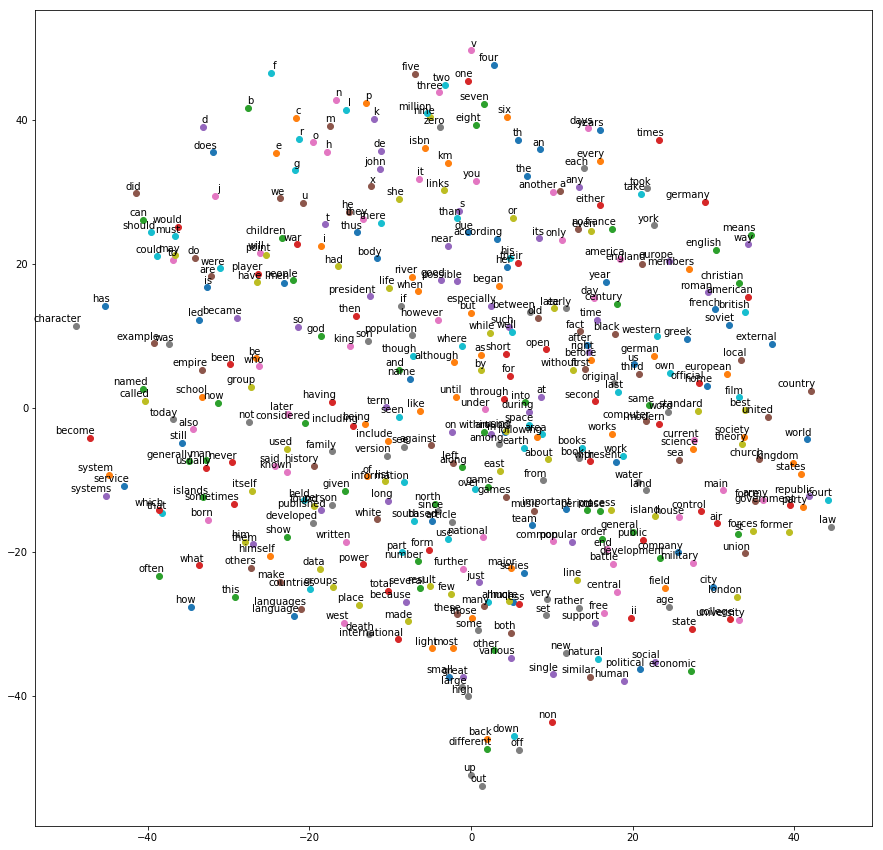

In [29]:
num_points = 400
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])


def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)